Notebook objective: Test fixed effects linear model, with store_id as target encoded predictor, and with rank deficient columns dropped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
#pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

In [3]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "10"

# Preprocessing

In [4]:
random_state = 1923

In [5]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [6]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [7]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [8]:
# Get rid of rank-deficiency by dropping highly correlated columns
# The below setting gets rid of the rank deficiency error & yields the best testing performance
df = df.drop(
    [
    "num_distinct_items", 
    "total_outstanding_orders", 
    "total_busy_dashers", 
    #"total_onshift_dashers",
    #"total_available_dashers"
], axis = 1)

In [9]:
# Split features and target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [10]:
train_end = int(len(df) * 0.6)

In [11]:
val_end = train_end + int(len(df) * 0.2)

In [12]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [13]:
# Create target encoders & scaler

# store_id encoder with hierarchy, top level market_id
hierarchy = pd.DataFrame(X["market_id"]).rename({"market_id": "HIER_store_id_1"}, axis = 1)
encoder_storeid = TargetEncoder(cols = ["store_id"], hierarchy = hierarchy)

# Encoder for remaining categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "store_primary_category", "order_protocol"])

# Standard scaler
#scaler = StandardScaler()

pipeline = Pipeline([
    ("encoder_storeid", encoder_storeid),
    ("encoder", encoder),
    #("scaler", scaler)
])

In [14]:
pipeline

Pipeline(steps=[('encoder_storeid',
                 TargetEncoder(cols=['store_id'],
                               hierarchy=        HIER_store_id_1
0                     1
1                     1
2                     1
3                     3
4                     2
...                 ...
110511                5
110512                4
110513                1
110514                1
110515                2

[110432 rows x 1 columns])),
                ('encoder',
                 TargetEncoder(cols=['market_id', 'store_primary_category',
                                     'order_protocol']))])

# Testing & diagnostics

In [15]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [16]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
#X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pipeline.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [17]:
# Train final model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
# Make predictions on test data
preds = model.predict(X_test)

In [19]:
preds

array([4623.646044, 3489.321529, 4220.466384, 3712.282188, 4458.866325,
       3132.748391, 2452.747885, ..., 2064.204275, 2569.585193,
       1310.213608, 2231.011423, 3090.417355, 3471.104049, 2741.059763])

In [20]:
# Combine back features & predictions
df_pred = X_test.copy()
df_pred["preds"] = preds
df_pred["actual"] = y_test.values
df_pred["residual"] = df_pred["actual"] - df_pred["preds"]

In [22]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
950.0470909837305
MAPE:
0.2454109949250952


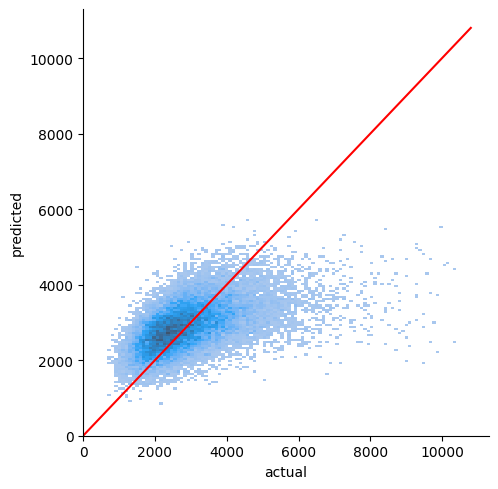

In [23]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

# Inference

In [26]:
# Print model parameters
coefs = model.coef_
intercept = model.intercept_

In [27]:
print(pd.Series(coefs, X_test.columns))
print("intercept:                                      " + str(intercept))

market_id                                          0.165647
store_id                                           0.930831
store_primary_category                            -0.188113
order_protocol                                     0.127382
total_items                                       15.398026
subtotal                                           0.074752
min_item_price                                    -0.022428
max_item_price                                    -0.023427
total_onshift_dashers                            -31.375321
estimated_order_place_duration                     0.419269
estimated_store_to_consumer_driving_duration       1.064713
weekday_0                                        206.985209
weekday_1                                        -13.380647
weekday_2                                        -51.767318
weekday_3                                         38.595284
weekday_4                                         20.613539
weekday_5                               

In [28]:
# Get SHAP values
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_train)

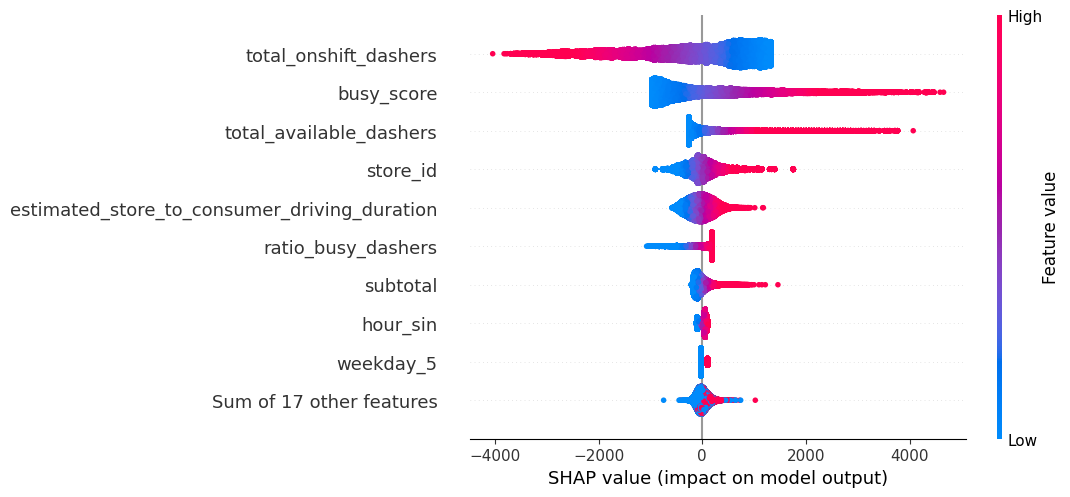

In [29]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

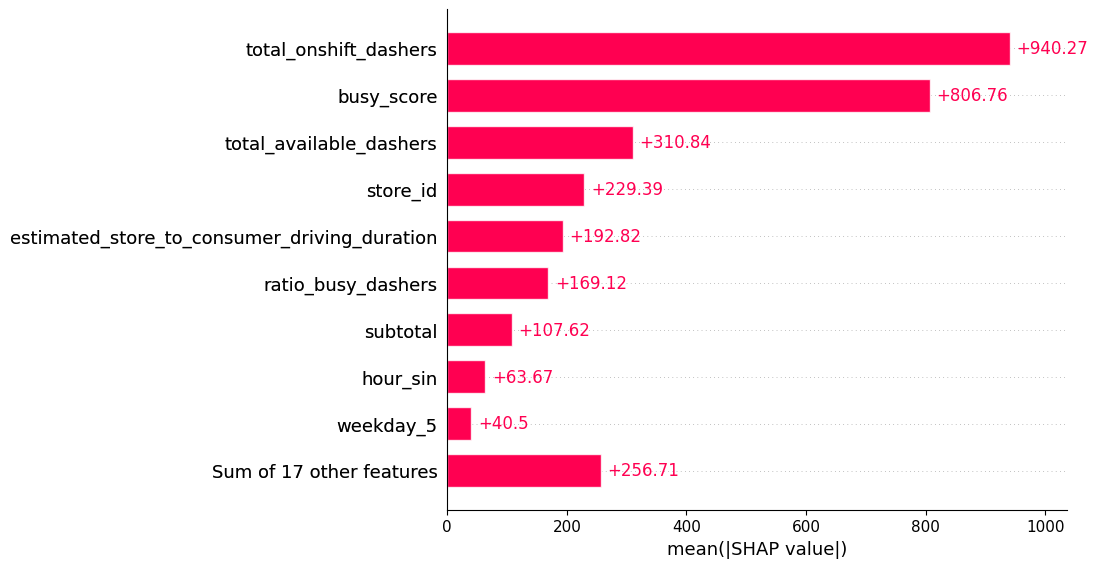

In [30]:
shap.plots.bar(shap_values)

# Findings
- Fairly close performance to XGBoost and LGBM, even though top features are considerably different.
- The learned relationship for cyclical minute features is different from XGB & LGBM.
- Top features according to SHAP are considerably different from XGB & LGBM.
- It's peculiar for store_primary_category to have a negative effect on predictions, as it is target encoded.
- Standardization leads to slightly better validation performance, but slightly worse testing performance.
- Performs slightly better than Gamma GLM with regularization.